In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter

import eli5

from pprint import pprint
from spacy import displacy
from collections import Counter
import en_core_web_sm

%matplotlib inline

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Retrieving Raw Data

In [3]:
# dataset taken from: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/version/4#ner_dataset.csv
raw_data = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

# "Tag" column uses:
#   1) IOB-2 format:
#     I: word is inside of a chunk
#     O: word is outside of a chunk
#     B: word is at tge beginning of a chunk
#     S: word is a single-word chunk
#     E: word is at end of chunk word
#   2) Entities:
#     geo: Geographical Entity
#     org: Organization
#     per: Person
#     gpe: Geopolitical Entity
#     tim: Time indicator
#     art: Artifact
#     eve: Event
#     nat: Natural Phenomenon
# "POS" column uses POS (Part of Speech Tagging)

# use a subset of the data due to memory constraints
raw_data = raw_data[:30000]

## 2. Dataset Analysis

In [4]:
raw_data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
print('Number of unique sentences: {}'.format(raw_data['Sentence #'].nunique()))
print('Number of unique words: {}'.format(raw_data.Word.nunique()))
print('Number of unique POS: {}'.format(raw_data.POS.nunique()))
print('Number of unique tags: {}'.format(raw_data.Tag.nunique()))

Number of unique sentences: 1344
Number of unique words: 5604
Number of unique POS: 40
Number of unique tags: 17


In [6]:
# Are tags evenly distributed
raw_data.groupby('POS').size().reset_index(name='counts').head(10)

,POS,counts
0,$,30
1,",",884
2,.,1342
3,:,28
4,;,10
5,CC,672
6,CD,696
7,DT,2888
8,EX,19
9,IN,3551


In [7]:
# Are tags evenly distributed
raw_data.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,46
1,B-eve,20
2,B-geo,821
3,B-gpe,650
4,B-nat,15
5,B-org,602
6,B-per,450
7,B-tim,516
8,I-art,25
9,I-eve,16


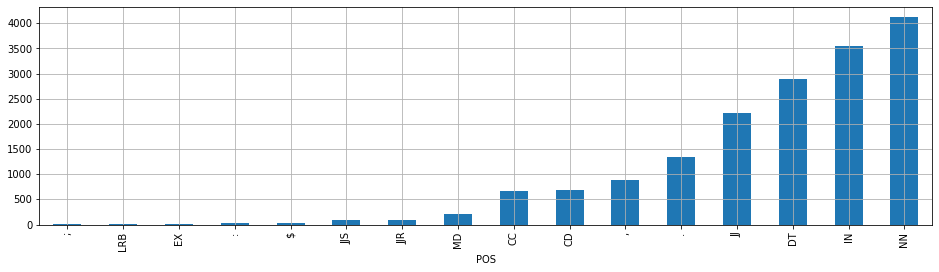

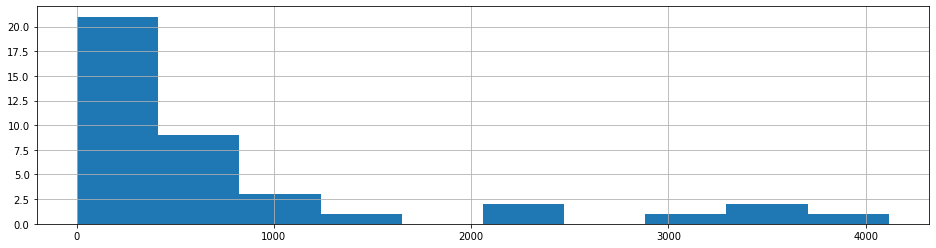

In [8]:
# plot POS count in ascending order
raw_data.groupby('POS').size().head(16).sort_values().plot(kind='bar', figsize=(16,4), grid=True)

plt.figure()

# plot POS histogram, excluding "O" tag
raw_data.groupby('POS').size().hist(figsize=(16,4))

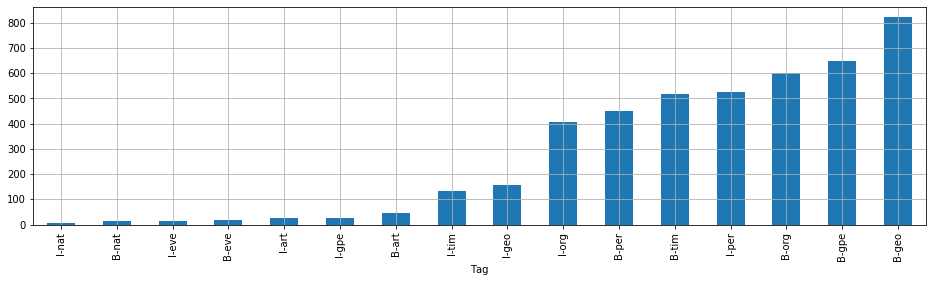

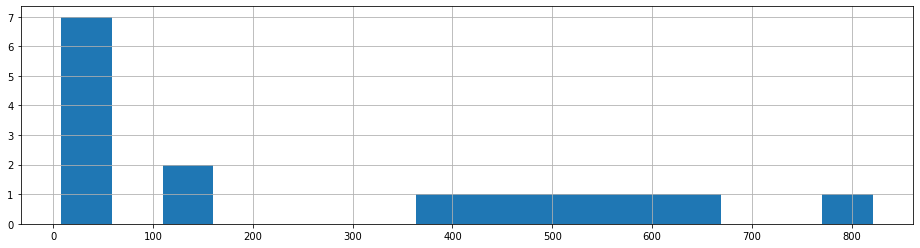

In [9]:
# plot Tag count in ascending order
raw_data.groupby('Tag').size().head(16).sort_values().plot(kind='bar', figsize=(16,4), grid=True)

# start a new figure
plt.figure()

# plot Tag histogram, excluding "O" tag
raw_data.groupby('Tag').size().head(16).hist(bins=16, figsize=(16,4))

## 3. Dataset Preparation

### 3.1. Filling NaNs

In [10]:
raw_data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [11]:
# check how many rows have NaNs
raw_data.isnull().sum()

Sentence #    28656
Word              0
POS               0
Tag               0
dtype: int64

In [12]:
# fill NaNs
data = raw_data.fillna(method='ffill')
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [13]:
# check NaNs still exist
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

### 3.2. Transforming Mappings to Numpy Arrays

In [16]:
# create "x" of training data by removing the "y" column ("Tag") from the dataset
x = data.drop('Tag', axis=1)

# print(x)

# DictVectorizer transformer turns lists of mappings (dict-like objects) of feature names 
# to feature values into Numpy arrays or scipy.sparse matrices for use with 
# scikit-learn estimators.
dv = DictVectorizer(sparse=False)
x = dv.fit_transform(x.to_dict('records'))

# create training data "y"
y = data.Tag.values

# print(dv.get_feature_names())
# print(x)
# print(y)

# select "classes"
classes = np.unique(y).tolist()
# print(classes)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

## 4. Spliting Dataset Into Train and Test

In [18]:
# split dataset into training and testing parts
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

classes_without_o = list(set(y_train) - {'O'})

# classification accuracy report
cr = dict()

## 5. Classifiers

### 5.1. SGD

In [19]:
%%time
model_sgd = SGDClassifier()
model_sgd.partial_fit(x_train, y_train, classes)

CPU times: user 3.5 s, sys: 0 ns, total: 3.5 s
Wall time: 3.5 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
report = classification_report(y_pred=model_sgd.predict(x_test), 
                               y_true=y_test, 
                               labels=classes_without_o, 
                               output_dict=True)
cr['sgd'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.2. Naive Bayes

In [21]:
%%time
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
model_nb.partial_fit(x_train, y_train, classes)

CPU times: user 1.89 s, sys: 12.7 ms, total: 1.9 s
Wall time: 396 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
report = classification_report(y_pred=model_nb.predict(x_test), 
                               y_true=y_test, 
                               labels=classes_without_o, 
                               output_dict=True)
cr['nb'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.4. Logistic Regression

In [138]:
%% time
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(n_jobs=-1)
model_lr.fit(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
report = classification_report(y_pred=model_lr.predict(x_test), 
                               y_true=y_test, 
                               labels=classes_without_o, 
                               output_dict=True)
cr['lr'] = report['weighted avg']

### 5.5. Support Vector Classifier

In [21]:
%%time
from sklearn import svm

model_svc = svm.SVC()
model_svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
report = classification_report(y_pred=model_svc.predict(x_test), 
                               y_true=y_test, 
                               labels=classes_without_o, 
                               output_dict=True)
cr['svc'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.6. Decission Tree

In [22]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

CPU times: user 1min 38s, sys: 34.8 ms, total: 1min 38s
Wall time: 1min 38s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [23]:
report = classification_report(y_pred=model_dt.predict(x_test), 
                               y_true=y_test, 
                               labels=classes_without_o, 
                               output_dict=True)
cr['dt'] = report['weighted avg']

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. Conditional Random Fields (CRFs)

### 6.1. Retrieve sentences with their POS and tags

In [24]:
# code from: 
# https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/
def create_sentences(data):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                       s['POS'].values.tolist(), 
                                                       s['Tag'].values.tolist())]
    grouped = data.groupby('Sentence #').apply(agg_func)
    sentences = [s for s in grouped]
    return sentences

# create CRF input sentences
sentences = create_sentences(data)

### 6.3. Feature extraction

In [25]:
# code taken from: 
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#features
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

### 6.4. Split Dataset Into Train and Test

In [26]:
x = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

### 6.5. Train CRF Model

In [27]:
# without hyper-tunning
model_crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                                 max_iterations=100, 
                                 all_possible_transitions=True)
model_crf.fit(x_train, y_train)

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

### 6.6. Evaluation

In [28]:
# print('raw: {}'.format(x_test[-4]))
# print('\nprocessed: {}'.format(sent2features(x_test[-4])))
print('Sentence: \n' + ' '.join([w['word.lower()'] for w in x_test[-4]]))
y_pred = model_crf.predict(x_test)
print('\nFound entities:')
print([(w['word.lower()'], en) for w, en in zip(x_test[-4], y_pred[-4]) if en != 'O'])
print('\n')
print(metrics.flat_classification_report(y_test, y_pred, labels = classes_without_o))
report = metrics.flat_classification_report(y_pred=model_crf.predict(x_test), 
                                            y_true=y_test, 
                                            labels=classes_without_o, 
                                            output_dict=True)
cr['crf'] = report['weighted avg']

Sentence: 
scientists say the information from huygens - operated jointly by the american , european and italian space agencies - may provide clues about how primitive earth evolved into a life-bearing planet .

Found entities:
[('huygens', 'B-geo'), ('american', 'B-gpe'), ('european', 'B-gpe'), ('italian', 'B-gpe'), ('earth', 'B-geo')]


              precision    recall  f1-score   support

       I-per       0.86      0.90      0.88       108
       B-art       1.00      0.13      0.24        15
       B-per       0.88      0.80      0.84       104
       B-nat       0.00      0.00      0.00         6
       I-gpe       0.50      0.40      0.44         5
       B-org       0.61      0.65      0.63       116
       I-geo       0.52      0.47      0.49        30
       B-eve       0.00      0.00      0.00         2
       I-art       0.00      0.00      0.00         5
       I-org       0.64      0.71      0.67        79
       I-tim       0.90      0.38      0.53        24
       I-n

### 6.7. Hyperparameter Tuning

In [138]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# define parameter search space
scale_c1 = 0.01
scale_c2 = 0.2

# define parameter distributions
param_space = {
    'c1': scipy.stats.expon(scale=scale_c1),
    'c2': scipy.stats.expon(scale=scale_c2)
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', 
                        labels=classes_without_o)

# search for the best parameters
rs = RandomizedSearchCV(model_crf,
                        param_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=100,
                        scoring=f1_scorer)

In [139]:
%%time
# fit the model
rs.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.0min finished


CPU times: user 5min 58s, sys: 370 ms, total: 5min 58s
Wall time: 6min 1s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2d5df55b90>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [140]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

model_crf_tuned = rs.best_estimator_
y_pred = model_crf_tuned.predict(x_test)

report = metrics.flat_classification_report(y_pred=model_crf_tuned.predict(x_test), 
                                            y_true=y_test, 
                                            labels=classes_without_o, 
                                            output_dict=True)
cr['crf_tuned'] = report['weighted avg']

best params: {'c1': 0.007728962749964885, 'c2': 0.07125223168576518}
best CV score: 0.7202647423945164
model size: 0.58M


/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6.8. Visualize Parameter Space

In [141]:
font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)

def plot_parameters(x, y, c, title=''):
    fig = plt.figure()
    fig.set_size_inches(12, 12)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('C1')
    ax.set_ylabel('C2')
    ax.set_title(title)
    
    if len(x) == len(c):
        ax.scatter(x, y, c=c, s=15, alpha=0.9)
    else:
        plt.plot(x, y, marker='.', color='k', linestyle='none')

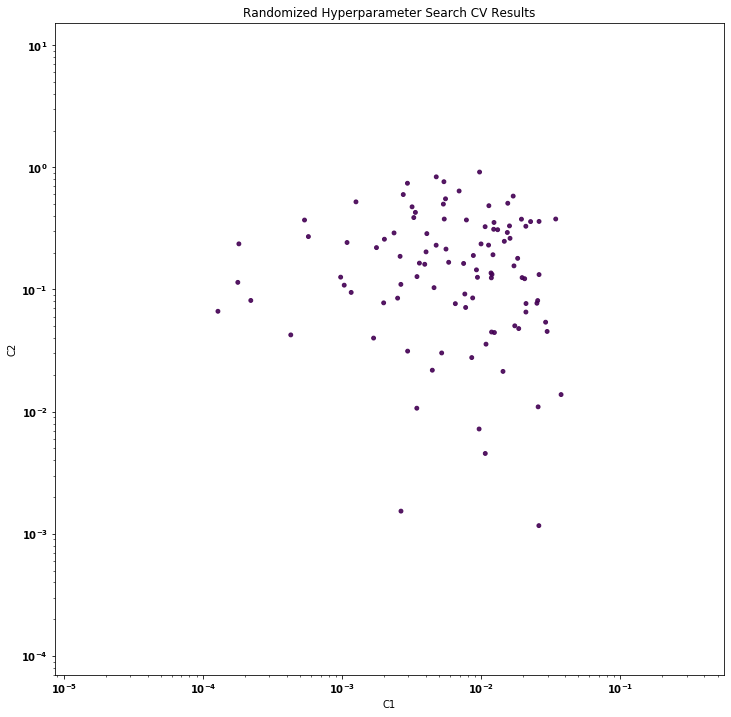

In [142]:
x = [_ for _ in rs.cv_results_['param_c1']]
y = [_ for _ in rs.cv_results_['param_c2']]
c = [0.5 for _ in rs.cv_results_['mean_test_score']]

# plot parameters - hypertuning
plot_parameters(x, y, c, "Randomized Hyperparameter Search CV Results")

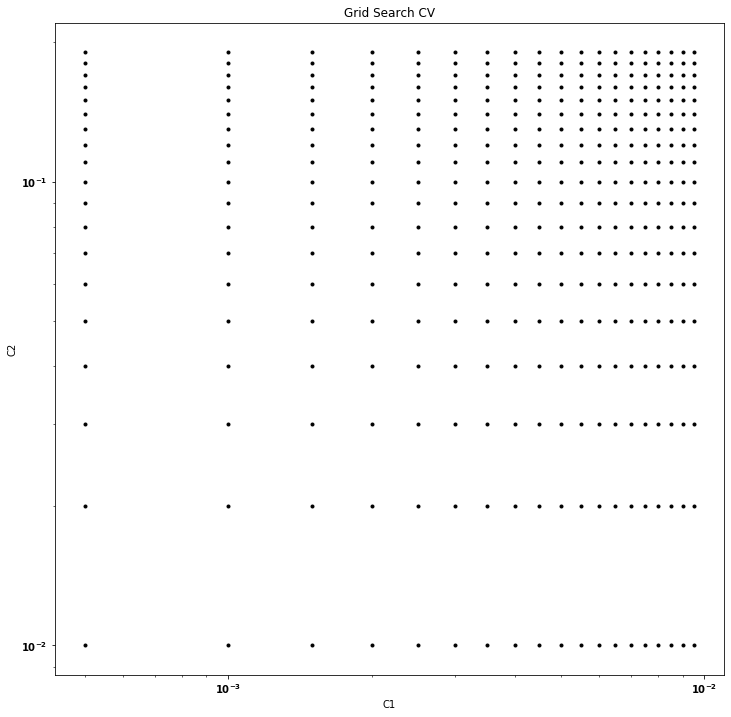

In [143]:
_x = np.arange(0, scale_c1, scale_c1 / 20)
_y = np.arange(0, scale_c2, scale_c2 / 20)

x, y = np.meshgrid(_x, _y)

x_ = np.hstack(x) # convert to 1-dimension array
y_ = np.hstack(y) # convert to 1-dimension array
c = [0.0 for _ in _x]

# plot parameters - hypertuning - grid format
plot_parameters(x_, y_, c=c, title="Grid Search CV")

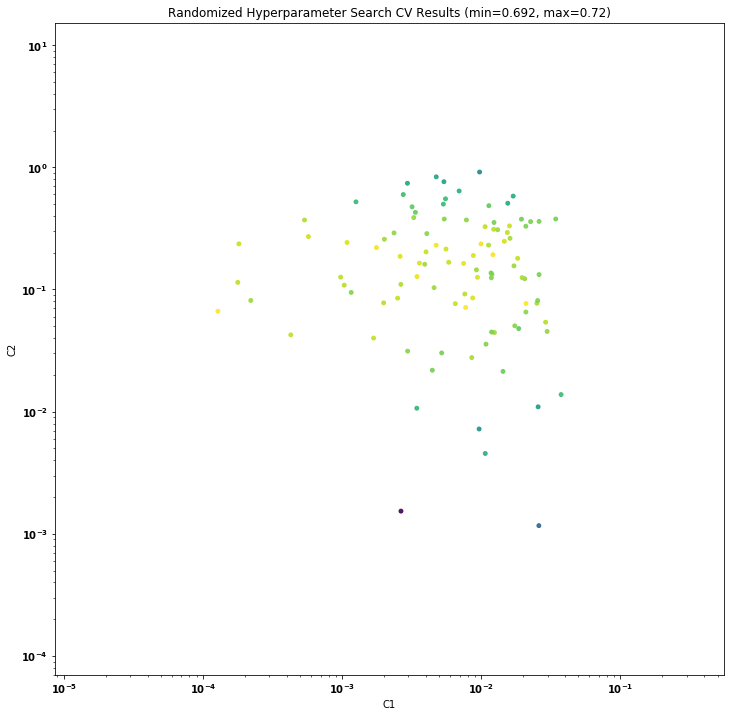

In [144]:
_x = [_ for _ in rs.cv_results_['param_c1']]
_y = [_ for _ in rs.cv_results_['param_c2']]
_c = [_ for _ in rs.cv_results_['mean_test_score']]

# plot parameters - hypertuning
plot_parameters(_x, _y, _c, title="Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))

### 6.8. Performance Compare

In [145]:
cr_df = pd.DataFrame.from_dict(cr, orient='index')
cr_df.head(10)

cr_df_perc = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'support'])
cr_df_perc.loc['sgd'] = (cr_df.loc['sgd'] - cr_df.loc['crf_tuned']) / cr_df.loc['sgd']
# cr_df_perc.loc['nb'] = (cr_df.loc['nb'] - cr_df.loc['crf_tuned']) / cr_df.loc['nb']
# cr_df_perc.loc['lr'] = (cr_df.loc['lr'] - cr_df.loc['crf_tuned']) / cr_df.loc['lr']
# cr_df_perc.loc['svc'] = (cr_df.loc['svc'] - cr_df.loc['crf_tuned']) / cr_df.loc['svc']
cr_df_perc.loc['dt'] = (cr_df.loc['dt'] - cr_df.loc['crf_tuned']) / cr_df.loc['dt']
cr_df_perc.loc['crf'] = (cr_df.loc['crf'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf']
cr_df_perc.loc['crf_tuned'] = (cr_df.loc['crf_tuned'] - cr_df.loc['crf_tuned']) / cr_df.loc['crf_tuned']
cr_df_perc.head(20)

,precision,recall,f1-score,support
sgd,-0.148299,-0.459790,-0.421906,-0.08024
dt,-0.153768,-0.219423,-0.195875,-0.08024
crf,-0.011846,-0.017054,-0.016765,0.00000
crf_tuned,0.000000,0.000000,0.000000,0.00000


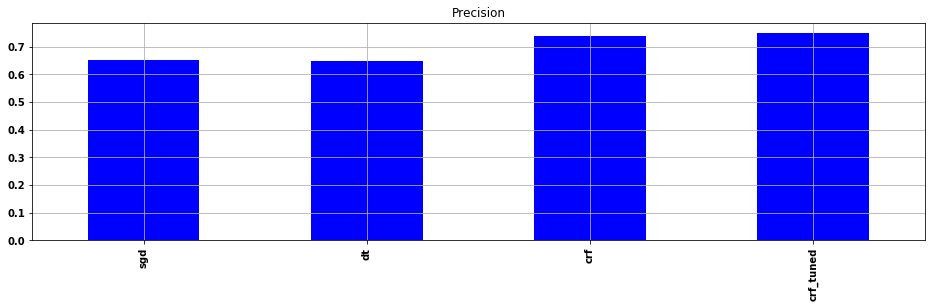

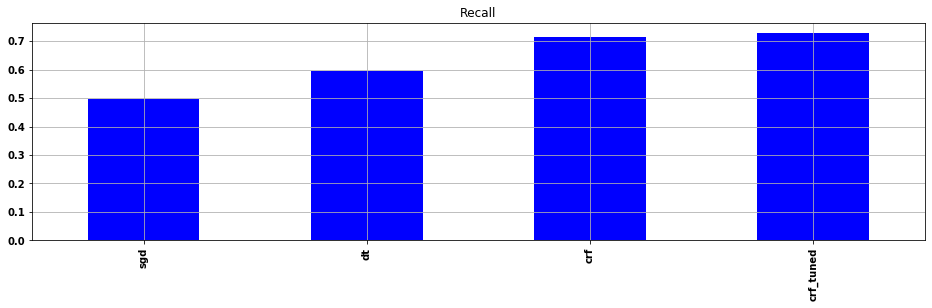

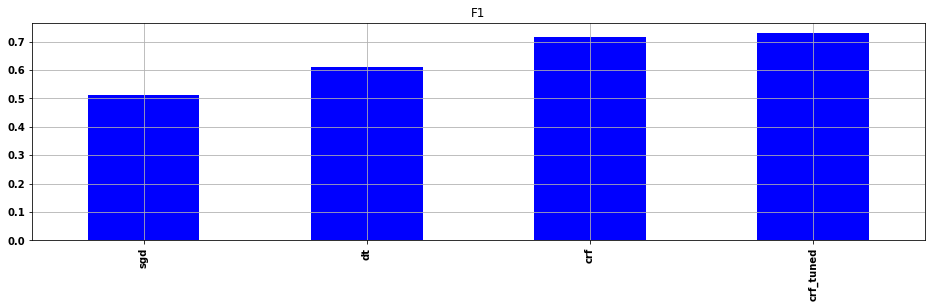

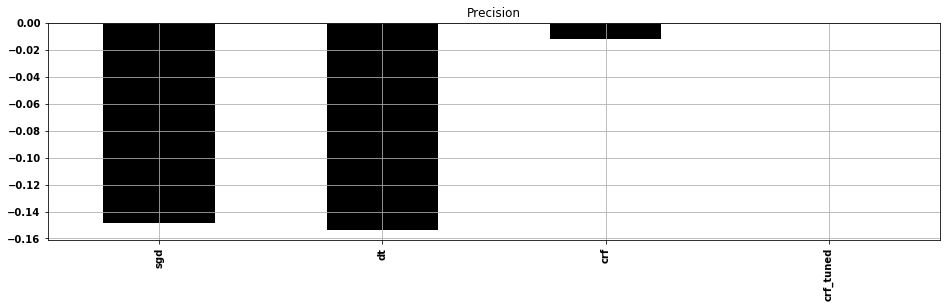

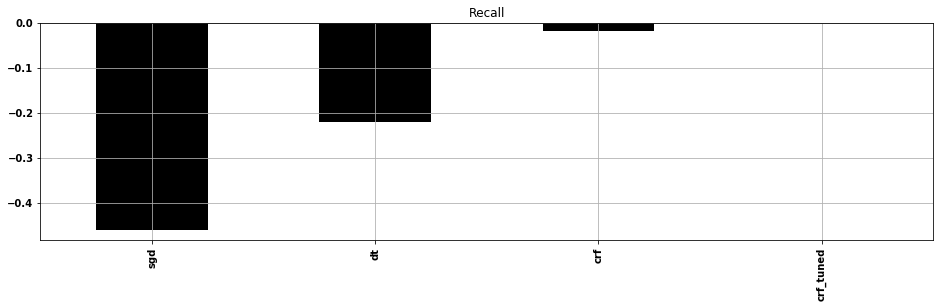

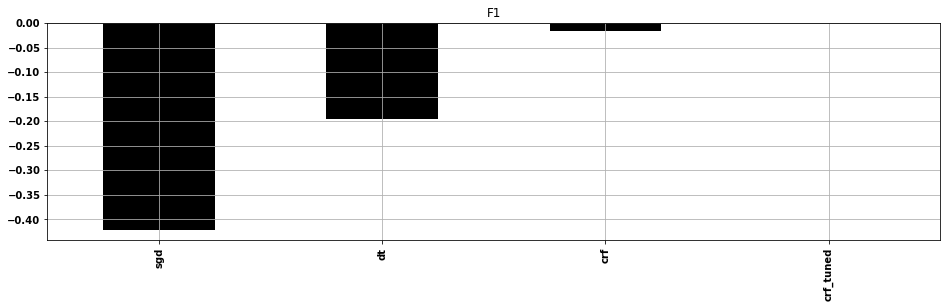

In [146]:
cr_df['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision', color='blue')
plt.show()

cr_df['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall', color='blue')
plt.show()

cr_df['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1', color='blue')
plt.show()

cr_df_perc['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision', color='black')
plt.show()

cr_df_perc['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall', color='black')
plt.show()

cr_df_perc['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1', color='black')
plt.show()

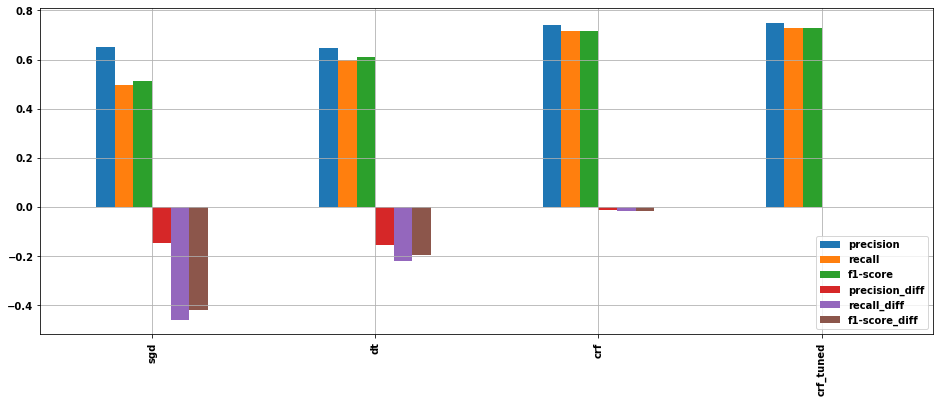

In [147]:
df_merge = cr_df.join(cr_df_perc, rsuffix='_diff')
df_merge.head(10)
df_merge = df_merge.drop(['support', 'support_diff'], axis=1)

ax = df_merge.plot(kind='bar', figsize=(16,6), grid=True)
# x_offset = -0.03
# y_offset = 0.02
# for p in ax.patches:
#     b = p.get_bbox()
#     val = "{:+.2f}".format(b.y1 + b.y0)        
#     ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

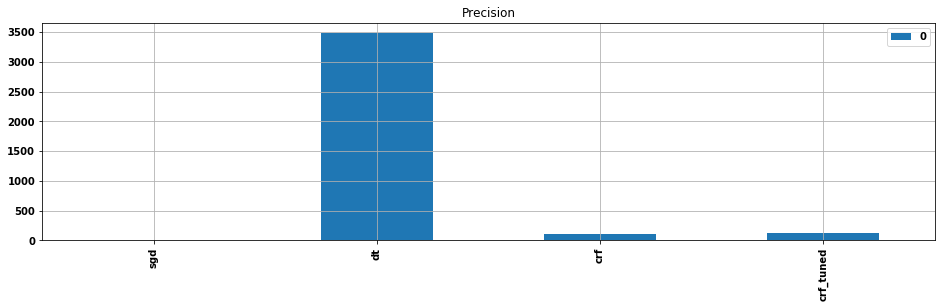

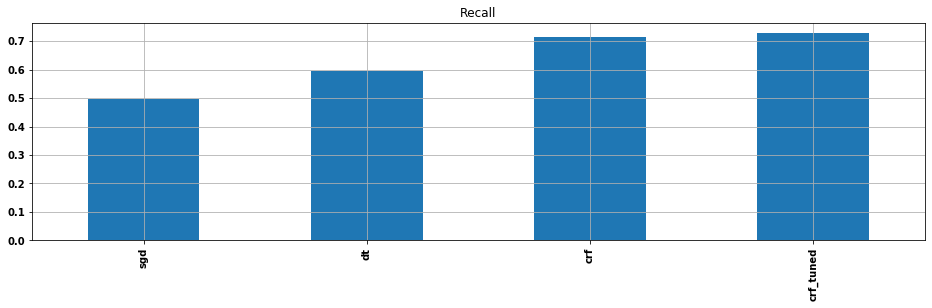

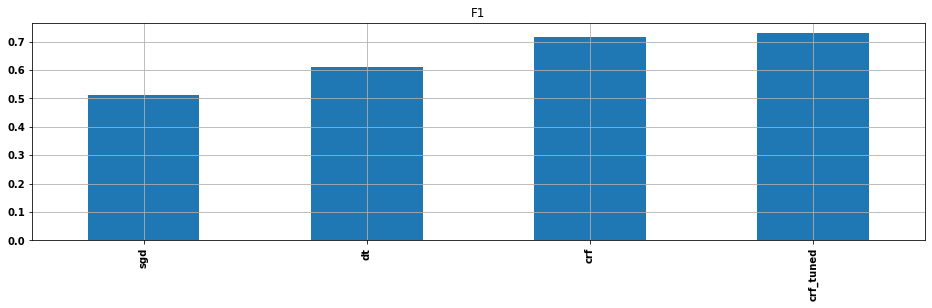

KeyError: 'nb'

In [148]:
# model training time
time_df = pd.DataFrame.from_dict({'nb': 0.397, 'svc': 3480, 'dt': 101, 'lr': 121, 'sgd': 4}, orient='index')
time_df.plot(kind='bar', grid=True, figsize=(16,4), title='Precision')

# model accuracy
cr_df = pd.DataFrame.from_dict(cr, orient='index')

cr_df['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision')
plt.show()

cr_df['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall')
plt.show()

cr_df['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1')
plt.show()

# compute percentage difference to the best
cr_df_perc = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'support'])
cr_df_perc.loc['nb'] = (cr_df.loc['nb'] - cr_df.loc['dt']) / cr_df.loc['nb'] * 100
cr_df_perc.loc['sgd'] = (cr_df.loc['sgd'] - cr_df.loc['dt']) / cr_df.loc['sgd'] * 100
cr_df_perc.loc['svc'] = (cr_df.loc['svc'] - cr_df.loc['dt']) / cr_df.loc['svc'] * 100
cr_df_perc.loc['lr'] = (cr_df.loc['lr'] - cr_df.loc['dt']) / cr_df.loc['lr'] * 100
cr_df_perc.loc['dt'] = (cr_df.loc['dt'] - cr_df.loc['dt']) / cr_df.loc['dt'] * 100

# plot differences in % difference
cr_df_perc['precision'].plot(kind='bar', grid=True, figsize=(16,4), title='Precision')
plt.show()

cr_df_perc['recall'].plot(kind='bar', grid=True, figsize=(16,4), title='Recall')
plt.show()

cr_df_perc['f1-score'].plot(kind='bar', grid=True, figsize=(16,4), title='F1')
plt.show()

No handles with labels found to put in legend.


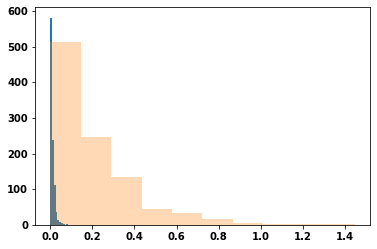

In [181]:
from scipy.stats import expon
import matplotlib.pyplot as plt
r1 = expon.rvs(size=1000, scale=0.01)
r2 = expon.rvs(size=1000, scale=0.2)
fig, ax = plt.subplots(1, 1)

#And compare the histogram:
ax.hist(r1)
ax.hist(r2, alpha=0.3)
ax.legend(loc='best', frameon=False)
plt.show()

### 6.9. Learned Transitions

In [57]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.3f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(model_crf_tuned.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(model_crf_tuned.transition_features_).most_common()[-20:])

Top likely transitions:
I-org  -> I-org   4.727
B-org  -> I-org   4.671
B-tim  -> I-tim   4.658
I-tim  -> I-tim   4.511
B-geo  -> I-geo   4.453
I-per  -> I-per   4.121
B-per  -> I-per   4.068
B-gpe  -> I-gpe   3.696
O      -> O       3.431
B-art  -> I-art   3.394
I-geo  -> I-geo   3.278
I-art  -> I-art   3.195
B-eve  -> I-eve   3.122
I-gpe  -> I-gpe   2.508
O      -> B-per   2.355
B-nat  -> I-nat   2.257
I-eve  -> I-eve   2.119
B-org  -> B-art   1.883
B-gpe  -> B-org   1.675
O      -> B-org   1.634

Top unlikely transitions:
B-gpe  -> I-per   -0.959
B-org  -> I-geo   -1.005
B-geo  -> I-org   -1.008
O      -> I-gpe   -1.023
B-gpe  -> I-org   -1.087
B-gpe  -> I-geo   -1.088
B-tim  -> B-tim   -1.146
B-geo  -> I-per   -1.180
B-org  -> B-org   -1.195
B-org  -> I-per   -1.197
B-tim  -> B-gpe   -1.199
I-per  -> B-per   -1.286
O      -> I-art   -1.327
I-org  -> I-per   -1.348
B-per  -> B-per   -1.706
O      -> I-per   -1.899
B-gpe  -> B-gpe   -1.991
O      -> I-geo   -2.145
O      -> I-tim   -

<b>Top Likely Transaction Interpretations</b>
<ul>
  <li><font color="blue">B-org  -> I-org   3.899</font> - a token from the beginning of a geographical entity (B-geo) to a token inside geographical entity (I-geo)</li>
  <li><font color="blue">I-org  -> I-org   3.867</font> - a token from inside an organization entity (I-org) to another token from inside a geographical entity (I-geo)</li>
  <li><font color="blue">B-per  -> I-per   3.678</font> - a token from beginning of a person entity (I-per) to another token from inside a person entity (I-per)</li>
</ul>

<b>Top Unlikely Tranction Interpretations</b>
<ul>
  <li><font color="blue">B-org  -> I-geo</font> - a token from beginning of an organization name (B-org) to another token from inside of a geographical entity (I-geo).</li>
  <li><font color="blue">B-geo  -> I-gpe</font> - a token from beginning of a geographical entity (B-geo) to another token from inside of a geo-political entity (I-gpe).</li>
  <li><font color="blue">B-tim  -> B-tim</font> - a token from beginning of a time entity (B-tim) to another token from the beginning of a time entity (B-tim).</li>
</ul>

### 6.10. Check the state features

In [58]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.2f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(model_crf_tuned.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(model_crf_tuned.state_features_).most_common()[-30:])

Top positive:
3.95 B-tim    word[-2:]:0s
3.94 O        BOS
3.83 O        bias
3.78 B-tim    word[-2:]:ay
3.68 B-tim    word[-3:]:day
3.27 B-gpe    word.istitle()
2.66 B-per    BOS
2.60 B-per    +1:word.lower():administration
2.48 O        word.lower():israeli-palestinian
2.43 B-org    word.lower():al-qaida
2.38 B-tim    word[-3:]:ber
2.26 O        -1:word.lower():prime
2.24 B-tim    -1:word.lower():year
2.24 B-org    word.lower():hamas
2.21 B-tim    +1:word.lower():year
2.20 I-tim    word[-2:]:ay
2.13 O        postag[:2]:VB
2.07 B-geo    -1:word.lower():in
2.03 I-tim    word[-3:]:day
2.02 B-org    word[-3:]:ban
1.94 B-tim    word.lower():by-election
1.94 B-gpe    postag:JJ
1.93 B-geo    word.lower():second-in-command
1.89 B-gpe    word[-2:]:an
1.87 B-gpe    -1:word.lower():recognize
1.86 O        +1:word.lower():summit
1.84 B-tim    -1:word.lower():parliamentary
1.84 B-org    word[-3:]:uay
1.83 B-org    word.lower():taleban
1.83 B-tim    +1:word.lower():months

Top negative:
-1.07 O   

<b>Top Positive Learned Patterns</b>
<ul>
  <li><font color="blue">5.183603 B-tim word[-3]:day</font> - if a nearby word was “day” then the token is likely a part of a Time indicator.</li>
  <li><font color="blue">1.40 B-org    word.isupper()</font> - token Organization at the beginning of a chunk is more likely to be upper-case</li>
  <li><font color="blue">-3.087828 O word.isdigit()</font> - digits are likely entities.</li>
  <li><font color="blue">-3.233526 O word.istitle()</font> - TitleCased words are likely entities.</li>
</ul>

<b>Top Negative Learned Patterns</b>
<ul>
  <li><font color="blue">-0.73 I-tim    word.istitle()</font> - title words in the interior of titles are not time tokens</li>
</ul>  

## 6.11. Inspect model weights

In [59]:
eli5.show_weights(model_crf, top=10)

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.148,0.738,-1.015,0.707,-0.695,1.328,-1.409,1.088,-0.738,0.23,-0.579,1.589,-1.866,1.709,-1.186,1.58,-1.928
B-art,-0.431,-0.031,2.412,-0.024,-0.14,-0.12,-0.214,-0.134,-0.156,-0.022,-0.083,-0.174,-0.243,-0.278,-0.343,0.081,-0.166
I-art,-0.436,-0.027,2.217,-0.018,-0.1,-0.153,-0.168,-0.122,-0.101,-0.02,-0.068,-0.128,-0.199,-0.33,-0.333,-0.15,-0.093
B-eve,-0.518,-0.025,-0.15,-0.028,2.263,-0.117,-0.201,-0.144,-0.141,-0.019,-0.067,-0.154,-0.249,-0.269,-0.29,-0.16,-0.105
I-eve,-0.46,-0.01,-0.077,-0.016,1.309,-0.05,-0.085,-0.064,-0.06,-0.016,-0.038,-0.081,-0.109,-0.168,-0.194,-0.078,-0.062
B-geo,0.104,-0.085,-0.563,-0.083,-0.437,-0.33,3.471,0.603,-0.62,-0.074,-0.309,-0.443,-0.716,-0.468,-0.872,0.781,-0.561
I-geo,-0.108,-0.031,-0.2,-0.026,-0.133,-0.164,2.178,-0.105,-0.138,-0.028,-0.093,-0.141,-0.284,-0.389,-0.374,-0.11,-0.184
B-gpe,0.755,-0.132,-0.407,-0.103,-0.315,-0.494,-0.654,-0.943,2.534,-0.079,-0.207,1.157,-0.734,0.43,-0.635,-0.44,-0.502
I-gpe,-0.352,-0.015,-0.065,-0.009,-0.042,-0.088,-0.062,-0.074,1.235,-0.01,-0.029,-0.067,-0.121,-0.205,-0.161,-0.07,-0.054
B-nat,-0.556,-0.013,-0.088,-0.01,-0.067,-0.082,-0.107,-0.08,-0.075,-0.013,1.494,-0.097,-0.115,-0.177,-0.212,-0.147,-0.064


# 6.11.1. Observations

<ul>
  <li>Model has learned that I-entity must follow B-entity, such as I-geo follows B-geo, I-org follows B-org, I-per follows B-per, and so on.</li>
  <li>It is unlikely in this data set to have a person right after an organization name (B-org -> I-per has a large negative weight).</li>
  <li>The model learned large negative weights for highly unlikely transitions like O -> I-geo, O -> I-org and O -> I-tim, and so on.</li>
</ul>

In [60]:
# check only a subset of tags:
eli5.show_weights(model_crf, top=10, targets=['O', 'B-org', 'I-per'])

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [61]:
# check only some of the features for all tags.
eli5.show_weights(model_crf, top=10, feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

/home/andrei/work/repos/datascience/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Weight?,Feature
-1.616,word.isupper()
-1.662,word.isdigit()
-2.925,word.istitle()
Weight?,Feature
+0.078,word.isupper()
-0.090,word.isdigit()
-0.096,word.istitle()
Weight?,Feature
+0.311,word.isdigit()
+0.041,word.istitle()


## 7. Spacy NER

In [62]:
# download with: "python -m spacy download en_core_web_md"
spacy_ner = en_core_web_sm.load()

In [63]:
# doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
input = ' '.join([w['word.lower()'] for w in x_test[-4]])
print('INPUT: {}\n'.format(input))

output = spacy_ner(input)
print('OUTPUT: {}'.format([(x.text, x.label_) for x in output.ents]))

INPUT: scientists say the information from huygens - operated jointly by the american , european and italian space agencies - may provide clues about how primitive earth evolved into a life-bearing planet .

OUTPUT: [('american', 'NORP'), ('european', 'NORP'), ('italian', 'NORP')]


<b>PROs Spacy</b>
<ul>
    <li>Out-of-the box experience</li> 
    <li>Pre-trained model</li> 
    <li>Integrates with other library-specific features</li>
</ul>

<b>CONs Spacy</b>
<ul>
    <li>Not easy to tailor built-in models</li>
    <li>No information on how models were trained and what influences their features have</li>
    <li>Has a "black box"-like experience</li>
</ul>

<b>PROs Custom</b>
<ul>
    <li>Models can be tailored as much as possible</li>
    <li>Have good explainability feedback</li>
    <li>Datasets can be tailored to specific entities.</li>
</ul>

<b>CONs Custom</b>
<ul>
    <li>Models have to be built from scratch</li>
    <li>Finding good datasets is not easy.</li>
    <li>The time spent for developing model from scratch is not always worth it</li>
</ul>